In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
sys.path.append(os.path.abspath("/plotting.py"))
sys.path.append(os.path.abspath("/helper.py"))
import plotting
import helper
import itertools

import gym

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import time
from collections import defaultdict

np.random.seed(44)

%matplotlib inline

# Value Iteration Algorithm

- Adapted from https://github.com/dennybritz/reinforcement-learning/blob/master/DP/Value%20Iteration%20Solution.ipynb

In [158]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    diff = []
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value
        diff.append(delta)
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V, diff

# Policy Iteration Algorithm

In [159]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    diff = []
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            diff.append(delta)
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V), diff

def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):

    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    diff = []
    while True:
        # Evaluate the current policy
        V, temp = policy_eval_fn(policy, env, discount_factor)
        diff.append(temp)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V, diff

# Q Learning Algorithm

In [160]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    print("Policy: ", policy)
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

# Test Policy

In [161]:
def test_policy(env, policy, tests):
    
    rewards = []
    episode_counts = []
    
    for i in range(tests):
        
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        
        while not done and ep < 1000:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
            
            if ep > 1000:
                print("Failed to find Goal State.")
            
        rewards.append(episode_reward)
        episode_counts.append(ep)
    
    # all done
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts

# Analysis

#### Create environment

In [180]:
env = gym.make('FrozenLake8x8-v0')

In [181]:
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


#### Compare Policies

In [62]:
## The policies converge to the same value

start_time = time.time()
policy_vi, v, diff = value_iteration(env)
end_time = time.time()
print("VI Time: ", end_time - start_time)
policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))

start_time = time.time()
policy_pi, v, diff_pi = policy_improvement(env)
end_time = time.time()
print("PI Time: ", end_time - start_time)
policy_pi = np.reshape(np.argmax(policy_pi, axis=1), (8, 8))

policy_pi == policy_vi

VI Time:  0.7178640365600586
PI Time:  3.0647082328796387


array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [63]:
policy_vi

array([[1, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 2],
       [0, 0, 0, 0, 2, 3, 3, 2],
       [0, 0, 0, 1, 0, 0, 2, 2],
       [0, 3, 0, 0, 2, 1, 3, 2],
       [0, 0, 0, 1, 3, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 0, 2],
       [0, 1, 0, 0, 1, 2, 1, 0]])

#### Heatmap of Grid world

In [115]:
env.render()

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Starting Heatmap
Heatmap Finished


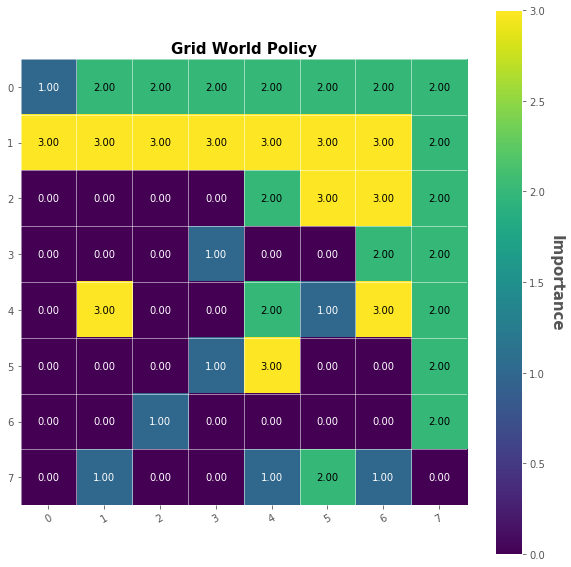

In [117]:
policy_vi, v, diff = value_iteration(env, discount_factor=gamma)
policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))

fig, ax1 = plt.subplots(figsize=(10, 10))
helper.heatmap(policy_vi,
        row_labels=np.arange(0, 28),
        col_labels=np.arange(0, 28),
        ax=ax1, cbarlabel="Importance",
        title="Grid World Policy",
        annotate=True)
# plt.savefig('FLHeatMap1.png')

Starting Heatmap
Heatmap Finished


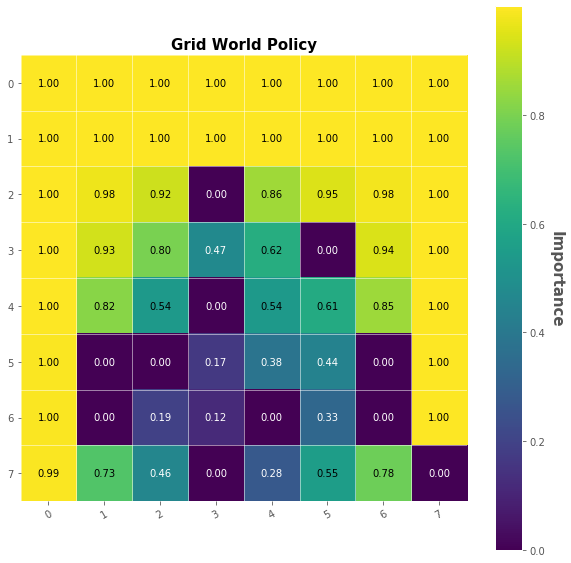

In [111]:
policy_vi, v, diff = value_iteration(env, discount_factor=gamma)
v = v.reshape(8, 8)

fig, ax1 = plt.subplots(figsize=(10, 10))
helper.heatmap(v,
        row_labels=np.arange(0, 28),
        col_labels=np.arange(0, 28),
        ax=ax1, cbarlabel="Importance",
        title="Grid World Policy",
        annotate=True)

#### Check Policy Convergence

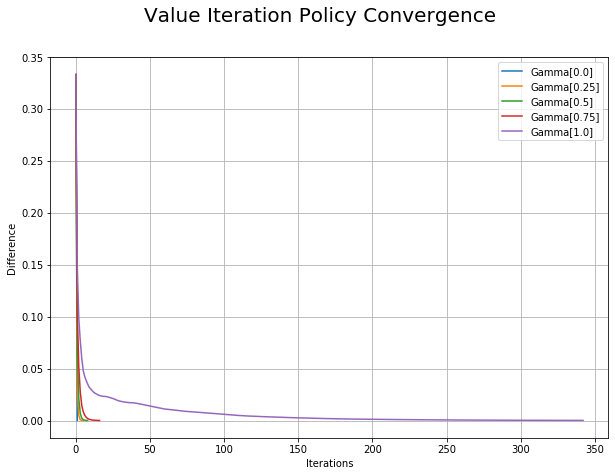

In [32]:
gammas = [0.0, 0.25, 0.50, 0.75, 1.0]
diff = []

for gamma in gammas:
    policy_vi, v, temp = value_iteration(env, discount_factor=gamma)
    diff.append(temp)

plt.figure(figsize=(10, 7))
plt.suptitle('Value Iteration Policy Convergence', fontsize=20)
plt.xlabel('Iterations')
plt.ylabel('Difference')
for i in range(len(diff)):
    label = "Gamma" + str([gammas[i]])
    plt.plot(diff[i], label=label)
plt.legend()
plt.grid()
# plt.savefig('VIConvergence.png')
plt.show()

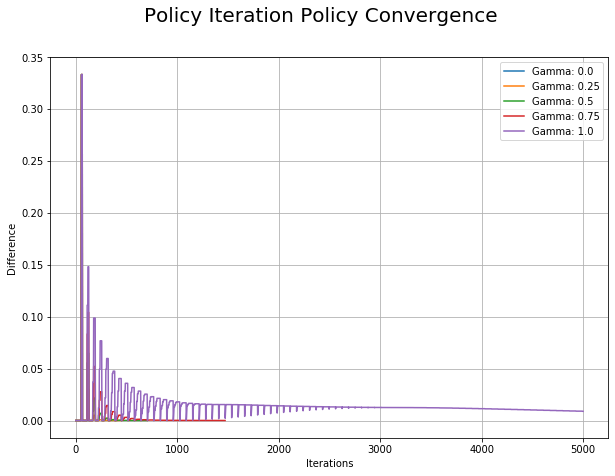

In [33]:
gammas = [0.0, 0.25, 0.50, 0.75, 1.0]
diff = []

for gamma in gammas:
    policy_vi, v, temp = policy_improvement(env, discount_factor=gamma)
    diff.append(temp[-1])


plt.figure(figsize=(10, 7))
plt.suptitle('Policy Iteration Policy Convergence', fontsize=20)
plt.xlabel('Iterations')
plt.ylabel('Difference')
for i in range(len(diff)):
    label = "Gamma: " + str(gammas[i])
    plt.plot(diff[i][0:5000], label=label)
plt.legend()
plt.grid()
plt.savefig('PIConvergence.png')
plt.show()

In [182]:
Q, stats = q_learning(env, num_episodes=100, discount_factor=1.0, alpha=0.5, epsilon=0.1)

Policy:  <function make_epsilon_greedy_policy.<locals>.policy_fn at 0x7ffd4e943560>
Episode 100/100.

In [183]:
Q

defaultdict(<function __main__.q_learning.<locals>.<lambda>()>,
            {0: array([0., 0., 0., 0.]),
             8: array([0., 0., 0., 0.]),
             16: array([0., 0., 0., 0.]),
             24: array([0., 0., 0., 0.]),
             32: array([0., 0., 0., 0.]),
             40: array([0., 0., 0., 0.]),
             48: array([0., 0., 0., 0.]),
             56: array([0., 0., 0., 0.]),
             33: array([0., 0., 0., 0.]),
             41: array([0., 0., 0., 0.]),
             25: array([0., 0., 0., 0.]),
             17: array([0., 0., 0., 0.]),
             57: array([0., 0., 0., 0.]),
             49: array([0., 0., 0., 0.]),
             1: array([0., 0., 0., 0.]),
             9: array([0., 0., 0., 0.]),
             18: array([0., 0., 0., 0.]),
             58: array([0., 0., 0., 0.]),
             2: array([0., 0., 0., 0.]),
             10: array([0., 0., 0., 0.]),
             34: array([0., 0., 0., 0.]),
             42: array([0., 0., 0., 0.]),
             26: 

#### Test various Discount Factors (Gamma)

In [ ]:
discount_mean = []
discount_episodes = []
gammas = np.linspace(0, 1.0, 10)
discount_mean_pi = []
discount_episodes_pi = []

for gamma in gammas:
    
    ## Come up with the policy
    policy_vi, v = value_iteration(env, theta=0.0001, discount_factor=gamma)
    policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))
    policy_pi, _ = policy_improvement(env, discount_factor=gamma)
    policy_pi = np.reshape(np.argmax(policy_pi, axis=1), (8, 8))
    final_policy = []
    final_policy_pi = []
    
    for i in range(policy_vi.shape[1]):
        for j in policy_vi[i]:
            final_policy.append(j)
    
    for i in range(policy_pi.shape[1]):
        for j in policy_pi[i]:
            final_policy_pi.append(j)
            
    ## Test performance of policy        
    tests = 50
    mean_reward, mean_eps, rewards, episode_counts = test_policy(env, final_policy, tests)
    discount_mean.append(mean_reward)
    discount_episodes.append(mean_eps)
    
    mean_reward, mean_eps, rewards, episode_counts = test_policy(env, final_policy_pi, tests)
    discount_mean_pi.append(mean_reward)
    discount_episodes_pi.append(mean_eps)
    
    
plt.figure()
plt.suptitle('Discount Factor vs Average Reward')
plt.xlabel('Discount Factor')
plt.ylabel('Average Reward')
plt.plot(gammas, discount_mean, label='Value Iteration')
plt.plot(gammas, discount_mean_pi, label='Policy Iteration')
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.suptitle('Discount Factor vs Average Episodes')
plt.xlabel('Discount Factor')
plt.ylabel('Average Episodes')
plt.plot(gammas, discount_episodes, label='Value Iteration')
plt.plot(gammas, discount_episodes_pi, label='Policy Iteration')
plt.grid()
plt.legend()
plt.show()

### Discount Factor Analysis

Average Rewards:  [0.0, 0.0, 0.0, 0.4, 0.5, 0.9, 0.5, 0.7, 0.8, 0.9, 0.9]


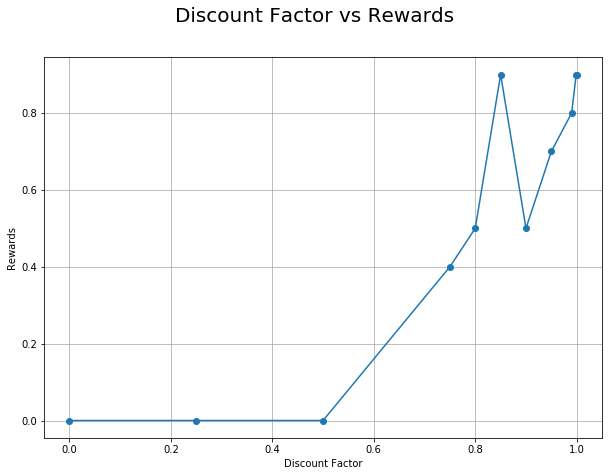

In [88]:
gammas = [0.0, 0.25, 0.50, 0.75, 0.80, 0.85, 0.9, 0.95, 0.99, 0.999, 1.0]
avg_reward = []

for gamma in gammas:
    policy_vi, v, diff = value_iteration(env, discount_factor=gamma)
    policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))
    
    final_policy = []
    
    for i in range(policy_vi.shape[1]):
        for j in policy_vi[i]:
            final_policy.append(j)
    
    
    mean_reward, mean_eps, rewards, episode_counts = test_policy(env, final_policy, tests=10)
    avg_reward.append(mean_reward)


print("Average Rewards: ", avg_reward)
  
    
plt.figure(figsize=(10, 7))
plt.suptitle('Discount Factor vs Rewards', fontsize=20)
plt.xlabel('Discount Factor')
plt.ylabel('Rewards')
plt.plot(gammas, avg_reward, '-o')
plt.grid()
# plt.savefig('FLGamma.png')
plt.show()

### Epsilon Convergence Value

Average Rewards:  [0.02, 0.02, 0.04, 0.2, 0.18, 0.16, 0.14, 0.3, 0.34, 0.1, 0.14, 0.14, 0.42, 0.32, 0.28, 0.38, 0.34, 0.5, 0.36, 0.52, 0.62, 0.54, 0.46, 0.58, 0.52, 0.42, 0.48, 0.46, 0.5, 0.5, 0.54, 0.56, 0.62, 0.54, 0.56, 0.56, 0.56, 0.58, 0.6, 0.52, 0.66, 0.68, 0.68, 0.64, 0.74, 0.54, 0.64, 0.6, 0.82, 0.84]


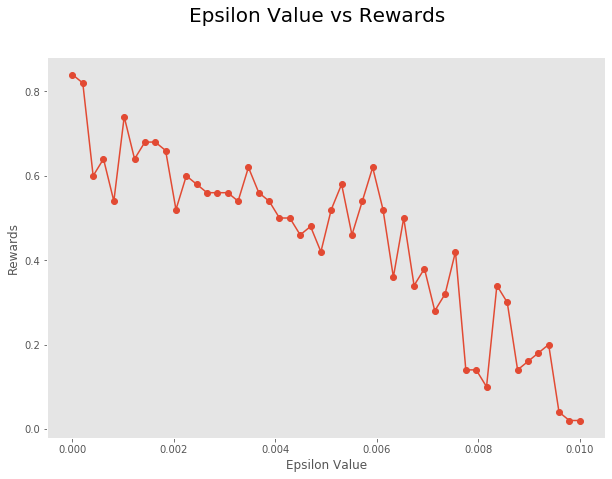

In [143]:
epsilons = np.linspace(1e-2, 1e-50, 50)
avg_reward = []

for epsilon in epsilons:
    policy_vi, v, diff = value_iteration(env, discount_factor=0.9, theta=epsilon)
    policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))
    
    final_policy = []
    
    for i in range(policy_vi.shape[1]):
        for j in policy_vi[i]:
            final_policy.append(j)
    
    
    mean_reward, mean_eps, rewards, episode_counts = test_policy(env, final_policy, tests=50)
    avg_reward.append(mean_reward)


print("Average Rewards: ", avg_reward)
  
    
plt.figure(figsize=(10, 7))
plt.suptitle('Epsilon Value vs Rewards', fontsize=20)
plt.xlabel('Epsilon Value')
plt.ylabel('Rewards')
plt.plot(epsilons, avg_reward, '-o')
plt.grid()
plt.savefig('FLEpsilon.png')
plt.show()

### Rewards Comparison for the three algorithms

Policy:  <function make_epsilon_greedy_policy.<locals>.policy_fn at 0x7ffd4fc7f0e0>
Episode 100/100.

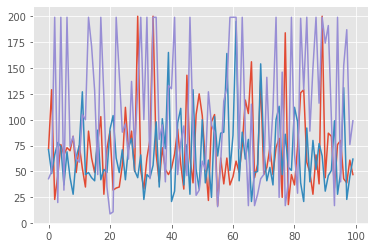

In [200]:
policy_vi, v, diff = value_iteration(env, discount_factor=0.9, theta=1e-6)
policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))
final_policy_vi = []
    
for i in range(policy_vi.shape[1]):
    for j in policy_vi[i]:
        final_policy_vi.append(j)

mean_reward_vi, mean_eps_vi, rewards_vi, episode_counts_vi = test_policy(env, final_policy_vi, tests=100)


policy_pi, v, diff = policy_improvement(env, discount_factor=0.9)
policy_pi = np.reshape(np.argmax(policy_pi, axis=1), (8, 8))
final_policy_pi = []
    
for i in range(policy_vi.shape[1]):
    for j in policy_vi[i]:
        final_policy_pi.append(j)

mean_reward_pi, mean_eps_pi, rewards_pi, episode_counts_pi = test_policy(env, final_policy_vi, tests=100)
        
Q, stats = q_learning(env, num_episodes=100, discount_factor=0.99, alpha=0.5, epsilon=0.1)


plt.figure()
plt.plot(episode_counts_vi)
plt.plot(episode_counts_pi)
plt.plot(stats[0])

In [202]:
print("Mean Episodes VI: ", mean_eps_vi)
print("Mean Episodes PI: ", mean_eps_pi)
print("Mean Episodes QLearning: ", np.mean(stats[0]))

Mean Episodes VI:  70.92
Mean Episodes PI:  66.91
Mean Episodes QLearning:  108.23


In [204]:
print("Mean Rewards VI: ", mean_reward_vi)
print("Mean Rewards PI: ", mean_reward_pi)
print("Mean Reward QL: ", np.mean(stats[1]))

Mean Rewards VI:  0.73
Mean Rewards PI:  0.74
Mean Reward QL:  0.0


 # Non-Stochastic Env

In [205]:
from gym.envs.toy_text import FrozenLakeEnv

env_2 = FrozenLakeEnv(map_name="8x8",is_slippery=True)
env_2.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


#### Compare Policies

In [206]:
## The policies converge to the same value

start_time = time.time()
policy_vi, v, diff = value_iteration(env_2)
end_time = time.time()
print("VI Time: ", end_time - start_time)
policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))

start_time = time.time()
policy_pi, v, diff_pi = policy_improvement(env_2)
end_time = time.time()
print("PI Time: ", end_time - start_time)
policy_pi = np.reshape(np.argmax(policy_pi, axis=1), (8, 8))

policy_pi == policy_vi

VI Time:  0.5396082401275635
PI Time:  2.452632188796997


array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

#### Visualizing the Policy

Starting Heatmap
Heatmap Finished


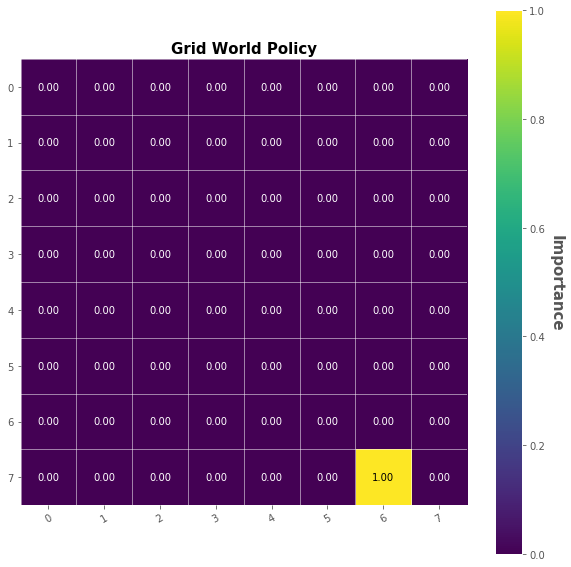

In [214]:
policy_vi, v, diff = value_iteration(env_2, discount_factor=gamma)
policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))

fig, ax1 = plt.subplots(figsize=(10, 10))
helper.heatmap(policy_vi,
        row_labels=np.arange(0, 28),
        col_labels=np.arange(0, 28),
        ax=ax1, cbarlabel="Importance",
        title="Grid World Policy",
        annotate=True)
# plt.savefig('FLHeatMap1.png')

Policy:  <function make_epsilon_greedy_policy.<locals>.policy_fn at 0x7ffd4feb19e0>
Episode 100/100.

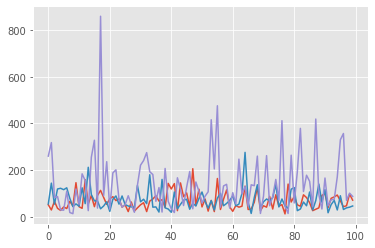

In [210]:
policy_vi, v, diff = value_iteration(env_2, discount_factor=0.9, theta=1e-6)
policy_vi = np.reshape(np.argmax(policy_vi, axis=1), (8, 8))
final_policy_vi = []
    
for i in range(policy_vi.shape[1]):
    for j in policy_vi[i]:
        final_policy_vi.append(j)

mean_reward_vi, mean_eps_vi, rewards_vi, episode_counts_vi = test_policy(env_2, final_policy_vi, tests=100)


policy_pi, v, diff = policy_improvement(env_2, discount_factor=0.9)
policy_pi = np.reshape(np.argmax(policy_pi, axis=1), (8, 8))
final_policy_pi = []
    
for i in range(policy_vi.shape[1]):
    for j in policy_vi[i]:
        final_policy_pi.append(j)

mean_reward_pi, mean_eps_pi, rewards_pi, episode_counts_pi = test_policy(env_2, final_policy_vi, tests=100)
        
Q, stats = q_learning(env_2, num_episodes=100, discount_factor=0.99, alpha=0.5, epsilon=0.1)


plt.figure()
plt.plot(episode_counts_vi)
plt.plot(episode_counts_pi)
plt.plot(stats[0])

In [211]:
print("Mean Episodes VI: ", mean_eps_vi)
print("Mean Episodes PI: ", mean_eps_pi)
print("Mean Episodes QLearning: ", np.mean(stats[0]))

Mean Episodes VI:  67.51
Mean Episodes PI:  71.82
Mean Episodes QLearning:  142.69


In [212]:
print("Mean Rewards VI: ", mean_reward_vi)
print("Mean Rewards PI: ", mean_reward_pi)
print("Mean Reward QL: ", np.mean(stats[1]))

Mean Rewards VI:  0.79
Mean Rewards PI:  0.76
Mean Reward QL:  0.0
